# UTC - EDA

Greg Welliver   

In [1]:
# Import relevant libraries and packages.
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.ticker as plticker
import seaborn as sns
sns.set()
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model, preprocessing 
import warnings
from scipy import stats
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import lightgbm as lgb
from lightgbm import LGBMRegressor
from numpy import mean
from numpy import std
from functools import partial
%matplotlib inline
from sklearn.linear_model import GammaRegressor
from sklearn.linear_model import TweedieRegressor

import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot
from scipy import stats

from sklearn.datasets import fetch_openml
from sklearn import linear_model, preprocessing, tree, svm, datasets, metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, auc, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, f1_score, log_loss
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import xgboost
from xgboost import XGBClassifier
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMClassifier


from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder as OHE
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_tweedie_deviance, make_scorer


import xgboost
from xgboost import XGBClassifier
from xgboost import XGBRegressor
import warnings
from subprocess import call
from IPython.display import Image
from datetime import datetime, timedelta, date
import os
import plotly.graph_objects as go
import itertools
from io import StringIO  
import pydotplus

# Seaborn settings
sns.set_context('notebook')
#sns.set_style("whitegrid")
#sns.set_style("white")
style_set = sns.set_style('whitegrid')
pd.options.display.float_format = '{:,}'.format
color_choice1 = 'plum'
color_choice2 = 'lightblue'
color_choice3 = 'lightgreen'
color_choice4 = 'blue'
#ax.yaxis.set_major_formatter('{x:,.0f}')
#sns.set_context('notebook', font_scale = 4)

#from mpl_toolkits.basemap import Basemap
import geopandas as gpd
from shapely.geometry import Point, Polygon
import contextily as ctx

from sklearn.feature_extraction.text import CountVectorizer
import json
from ydata_profiling import ProfileReport
import calendar


# Part 1 - EDA

## Load the data



In [2]:
# load data
df1 = pd.read_json('logins.json')
dfx1 = pd.read_json('ultimate_data_challenge.json')

In [3]:
df1.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


profile = ProfileReport(df1)
profile

## <font color='orange'>Data Quality Observations</font>
- according to the profiling report, there are 868 duplicate rows (0.9%) - there is no need to remove these, as it is possible that two users logged in at the same time
- there are not any nulls

In [4]:
days = list(calendar.day_abbr)
months = list(calendar.month_abbr)

In [5]:
df2 = df1

In [6]:
df2['count'] = 1

In [7]:
df2 = df2.set_index('login_time')

In [8]:
# group the logins by 15 minute intervals
df2g = df2.groupby(pd.Grouper(freq='15Min')).aggregate(np.sum) 
df2g['count'] = df2g['count'].fillna(0)
df2g.head(10)

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
1970-01-01 21:15:00,4
1970-01-01 21:30:00,0
1970-01-01 21:45:00,4
1970-01-01 22:00:00,9


## <font color='orange'>View the entire time series</font>

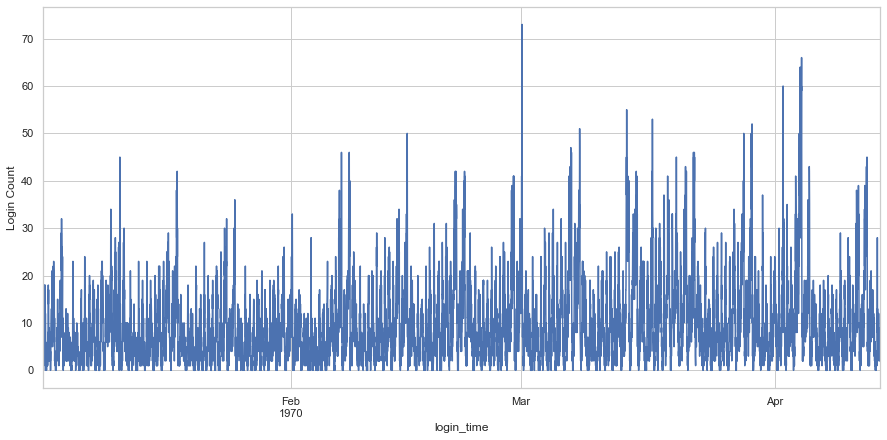

In [9]:
fig, ax = plt.subplots(figsize = (15 , 7))
ax.set_ylabel("Login Count" , size = 12 )
ax.set_xlabel( "Time" , size = 12 )
ax.yaxis.set_major_formatter('{x:,.0f}')
df2g['count'].plot();

#### Observations:
- It does appear that the data follows some sort of cyclical pattern.  We'll need to look more closely at shorter time intervals to get a better sense of the patterns

In [10]:
df2g = df2g.reset_index()

In [11]:
df2g.head()

,login_time,count
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


In [12]:
df2g['timestamp'] = pd.to_datetime(df2g.login_time)

In [13]:
df2g['month'] = df2g['timestamp'].apply(lambda x: months[x.month])
df2g['day'] = df2g['timestamp'].apply(lambda x: days[x.weekday()])
df2g['hour'] = df2g['timestamp'].apply(lambda x: x.hour)
df2g['time'] = df2g['timestamp'].apply(lambda x: x.time())

In [14]:
df2g.head()

,login_time,count,timestamp,month,day,hour,time
0,1970-01-01 20:00:00,2,1970-01-01 20:00:00,Jan,Thu,20,20:00:00
1,1970-01-01 20:15:00,6,1970-01-01 20:15:00,Jan,Thu,20,20:15:00
2,1970-01-01 20:30:00,9,1970-01-01 20:30:00,Jan,Thu,20,20:30:00
3,1970-01-01 20:45:00,7,1970-01-01 20:45:00,Jan,Thu,20,20:45:00
4,1970-01-01 21:00:00,1,1970-01-01 21:00:00,Jan,Thu,21,21:00:00


## <font color='orange'>Let's look at logins over the course of a day, by aggregating all of the days</font>

''

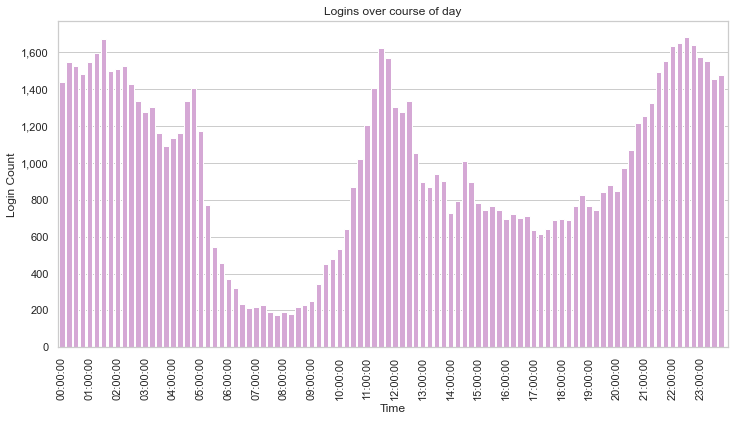

In [15]:
df_day = pd.DataFrame(df2g.groupby('time')['count'].sum().reset_index())
fig, ax = plt.subplots(figsize = (12 , 6))
plt.title("Logins over course of day")
sns.barplot(x = 'time', y = 'count', data = df_day,
            color = color_choice1
            )

ax.set_ylabel("Login Count" , size = 12 )
ax.set_xlabel( "Time" , size = 12 )
ax.yaxis.set_major_formatter('{x:,.0f}')
#plt.xticks(rotation=90)
plt.xticks(np.arange(0, len(df_day)+1, 4))
plt.xticks(rotation=90)
;

''

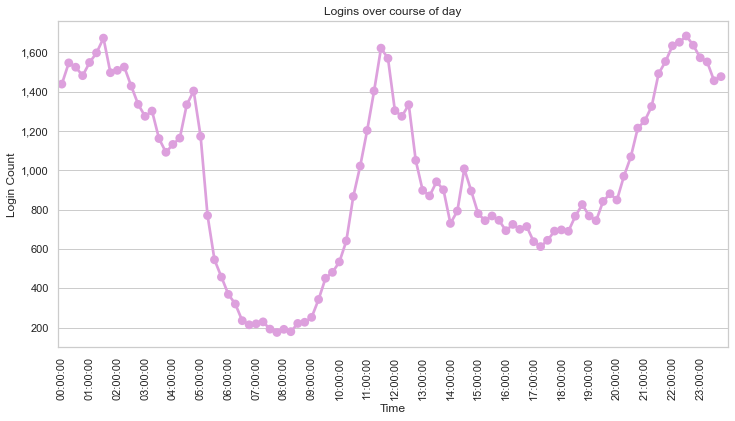

In [16]:
df_day = pd.DataFrame(df2g.groupby('time')['count'].sum().reset_index())
fig, ax = plt.subplots(figsize = (12 , 6))
plt.title("Logins over course of day")
sns.pointplot(x = 'time', y = 'count', data = df_day,
            color = color_choice1
            )

ax.set_ylabel("Login Count" , size = 12 )
ax.set_xlabel( "Time" , size = 12 )
ax.yaxis.set_major_formatter('{x:,.0f}')
#plt.xticks(rotation=90)
plt.xticks(np.arange(0, len(df_day)+1, 4))
plt.xticks(rotation=90)
;

#### Observations:
- Logins appear to peak later in the evening and early in the morning, with another peak around midday.  Usage bottoms at around 8AM, and the afternoon displays a meangingful dip from peak hours as well.

## <font color='orange'>Let's look at logins per day of week</font>

''

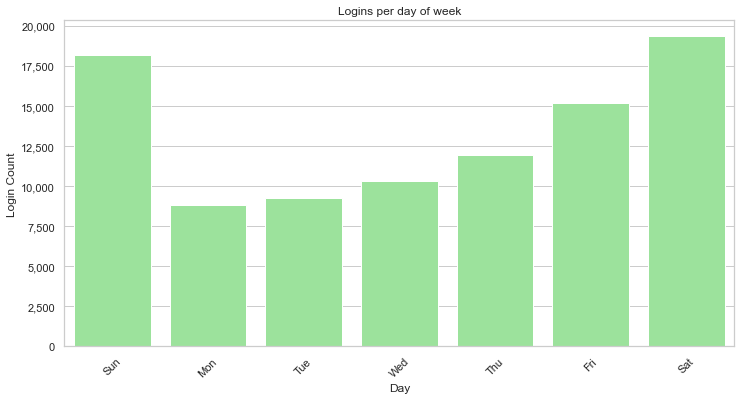

In [17]:
day_order = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
df_month = pd.DataFrame(df2g.groupby('day')['count'].sum().reset_index())
fig, ax = plt.subplots(figsize = (12 , 6))

plt.title("Logins per day of week")
sns.barplot(x = 'day', y = 'count', data = df_month,
            color = color_choice3, order=day_order
            )

ax.set_ylabel("Login Count" , size = 12 )
ax.set_xlabel( "Day" , size = 12 )
ax.yaxis.set_major_formatter('{x:,.0f}')
#plt.xticks(np.arange(0, len(df_month)+1, 4))
plt.xticks(rotation=45)
;

#### Observations:
- Usage peaks on Saturday and Sunday, with high volume on Thursday and Friday as well.  Usage is lowest on Monday and Tuesday (earlier in the week).  This is reminiscent of a food delivery service like DoorDash.

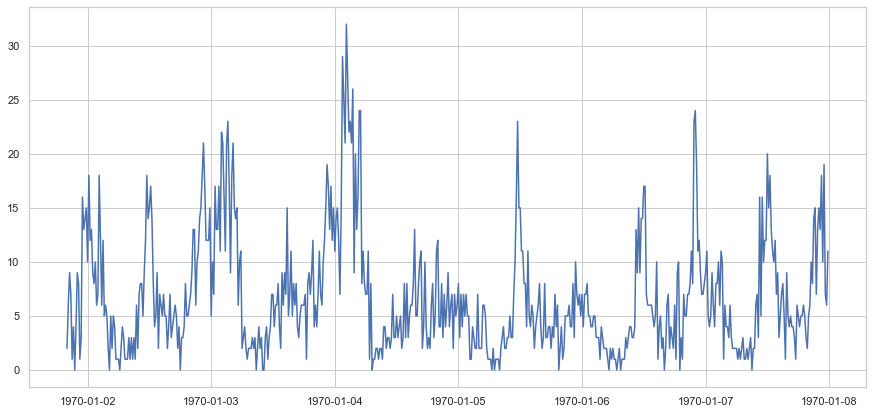

In [18]:
one_week = df2g[df2g['login_time'] < "1970-01-08"]
y = one_week['count']
x = one_week['login_time']

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(x,y)
plt.show()

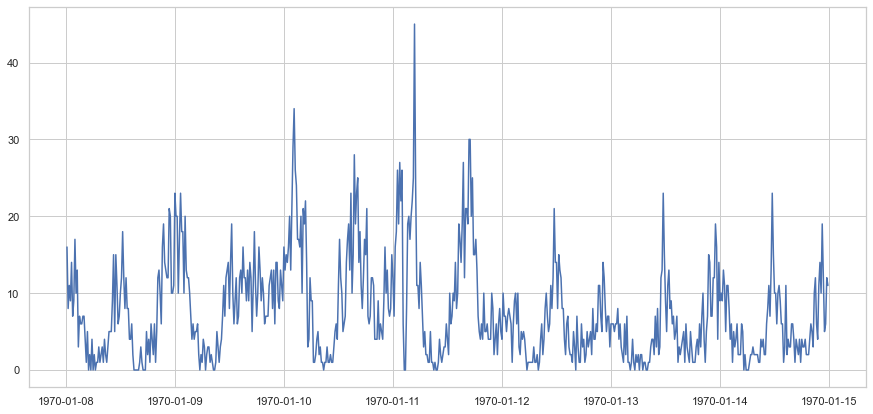

In [19]:
one_week = df2g[(df2g['login_time'] > "1970-01-08") & (df2g['login_time'] < "1970-01-15")]

y = one_week['count']
x = one_week['login_time']

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(x,y)
plt.show()

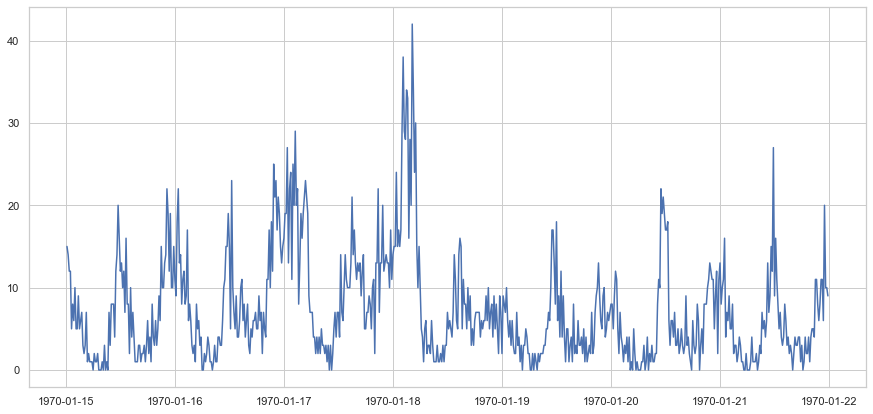

In [20]:
one_week = df2g[(df2g['login_time'] > "1970-01-15") & (df2g['login_time'] < "1970-01-22")]

y = one_week['count']
x = one_week['login_time']

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(x,y)
plt.show()

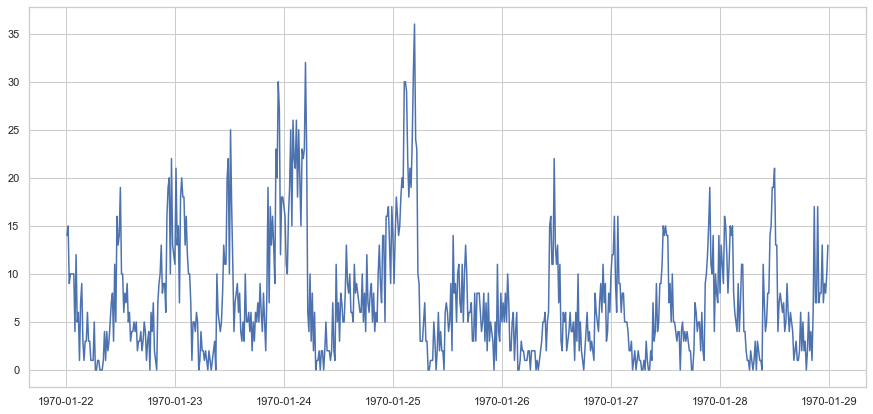

In [21]:
one_week = df2g[(df2g['login_time'] > "1970-01-22") & (df2g['login_time'] < "1970-01-29")]

y = one_week['count']
x = one_week['login_time']

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(x,y)
plt.show()

#### Observations:
- I selected a few random weeks to see if there was consistency week-to-week.  There does appear to be similar trends on a week-to-week basis.

## <font color='orange'>Let's look at logins per month</font>

''

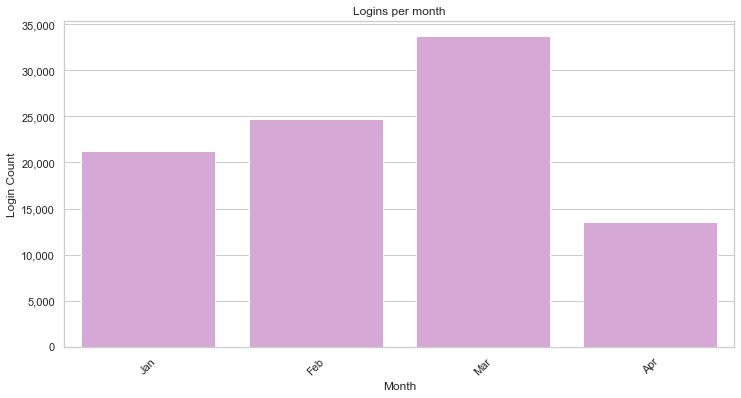

In [22]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr']
#df_day = pd.DataFrame(df2g.groupby('time')['count'].sum().sort_values(ascending=False).reset_index())
df_month = pd.DataFrame(df2g.groupby('month')['count'].sum().reset_index())
#df_day

fig, ax = plt.subplots(figsize = (12 , 6))
#plt.figure(figsize=(12,6))
plt.title("Logins per month")
sns.barplot(x = 'month', y = 'count', data = df_month,
            color = color_choice1, order=month_order
            )

#ax.set_ylabel("Damage (USD Billions)" , size = 12 )
ax.set_xlabel( "Month" , size = 12 )
ax.set_ylabel( "Login Count" , size = 12 )
ax.yaxis.set_major_formatter('{x:,.0f}')
#plt.xticks(rotation=90)
#plt.xticks(np.arange(0, len(df_month)+1, 4))
plt.xticks(rotation=45)
;

#### Observations:
- Usage steadily increased from the beginning of the year and peaked in March, with a precipitous decline in April. It would be itnerested to see if there was a similar quarterly pattern in the data for the duration of the year.

#### Let's look at logins over the course of a month

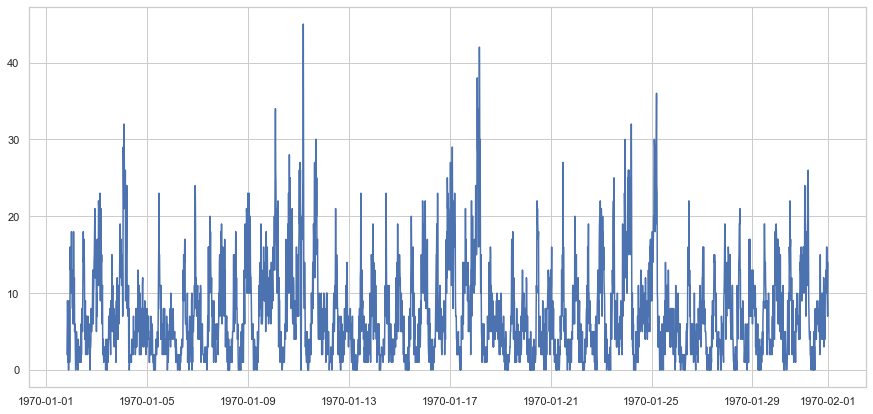

In [23]:
one_month = df2g[df2g['login_time'] < "1970-02-01"]
y = one_month['count']
x = one_month['login_time']

#plt.figure(figsize=(15,7))
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(x,y)
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.show()

# Part 2 - Experiment and metrics design

#### Question 1 - primary success metric
- I would choose the average earnings per day per driver as a success metric for this experiment.  This metric would indicate to us whether the changes we have made have improved the financial rewards for the drivers.  Presumably the drivers need to see improved earnings in order to travel the additional distance across the bridge.

#### Question 2 - experiment proposal

a) Experiment implementation
  - A/B test - split population 50/50
  - for the test variant, we will reimburse drivers that make the trip across the bridge.
  - control variant, everything would be the same
  - run the experiment for a period of time where we can get a read of statistical significance on the success metric
  - closely monitor other metrics that could indicate the overall quality of the experience - match rates, driver NPS, customer NPS, driver frequency of usage, driver retention


b) Statistical tests
  - Null hypothesis is that there is no change in driver earnings as a result of the change
  - Alternative hypothesis is that there is a change in driver earnings caused by the change
  - Run experiment at a 95% confidence interval


c) Interpretation
  - If we see evidence to reject the null hypothesis that there is a change in driver earnings caused by the experiment, we would recommend to roll out the feature to the entire population.
  - We would also want to monitor the other metrics mentioned above to ensure that there aren't any negative impacts on the driver and rider experiences.


# Part 3 - Predictive modeling

#### 1. Data cleaning & EDA
 - Remove duplicates
 - Handle nulls (below I imputed the median)
 - check for correlations
 - create an active_status feature


In [24]:
dfx1

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.1,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.0,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.0,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.1400000000000001,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.0,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.0,2014-01-25,iPhone,0.0,False,0.0,0.0,4.0
49997,Winterfell,0,2014-01-31,5.0,1.0,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.0,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


In [25]:
#profile = ProfileReport(dfx1)
#profile

In [26]:
#Drop duplicates
dfx1.drop_duplicates(keep='first', inplace=True)


In [27]:
dfx1 = dfx1.reset_index(drop=True)

In [28]:
dfx1.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

In [29]:
dfx1.signup_date.min()

'2014-01-01'

In [30]:
dfx1.signup_date.max()

'2014-01-31'

In [31]:
dfx1.last_trip_date.max()

'2014-07-01'

In [32]:
dfx1.last_trip_date.min()

'2014-01-01'

In [33]:
dfx1.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8119
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

#### Handle the nulls

In [34]:
# start with avg_rating_of_driver
dfx1.avg_rating_of_driver.describe()

count             41,873.0
mean    4.6015117139921236
std     0.6173599585421049
min                    1.0
25%                    4.3
50%                    4.9
75%                    5.0
max                    5.0
Name: avg_rating_of_driver, dtype: float64

In [35]:
dfx1.avg_rating_of_driver.median()

4.9

<AxesSubplot:>

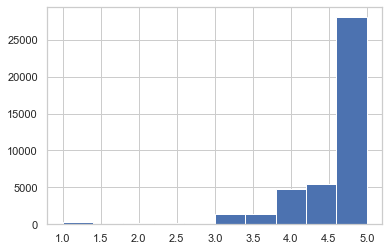

In [36]:
dfx1.avg_rating_of_driver.hist()

In [37]:
# impute with median for avg_rating_of_driver and avg_rating_by_driver
dfx1['avg_rating_of_driver'] = dfx1['avg_rating_of_driver'].fillna(dfx1['avg_rating_of_driver'].median())
dfx1['avg_rating_by_driver'] = dfx1['avg_rating_by_driver'].fillna(dfx1['avg_rating_by_driver'].median())

In [38]:
dfx1.phone.value_counts()

iPhone     34578
Android    15018
Name: phone, dtype: int64

In [39]:
# with 2/3 of phone values as iPhone, simply fill the remaining nulls as iPhone
dfx1['phone'] = dfx1['phone'].fillna('iPhone')

In [40]:
dfx1['ltd_timestamp'] = pd.to_datetime(dfx1['last_trip_date'], format="%Y-%m-%d")
dfx1.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,ltd_timestamp
0,King's Landing,4,2014-01-25,4.7,1.1,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,2014-06-17
1,Astapor,0,2014-01-29,5.0,1.0,2014-05-05,Android,0.0,False,50.0,8.26,5.0,2014-05-05
2,Astapor,3,2014-01-06,4.3,1.0,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,2014-01-07
3,King's Landing,9,2014-01-10,4.6,1.1400000000000001,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,2014-06-29
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,2014-03-15


Since we weren't given information on what is the current date of the analysis, I assume that the current date is the most recent last_trip_date

In [41]:
# set an active cutoff date of the latest last_trip_date - 30 days
dfx1['active_cutoff'] = pd.to_datetime(dfx1.last_trip_date.max(), format="%Y-%m-%d") - timedelta(days=30)

In [42]:
dfx1.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,ltd_timestamp,active_cutoff
0,King's Landing,4,2014-01-25,4.7,1.1,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,2014-06-17,2014-06-01
1,Astapor,0,2014-01-29,5.0,1.0,2014-05-05,Android,0.0,False,50.0,8.26,5.0,2014-05-05,2014-06-01
2,Astapor,3,2014-01-06,4.3,1.0,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,2014-01-07,2014-06-01
3,King's Landing,9,2014-01-10,4.6,1.1400000000000001,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,2014-06-29,2014-06-01
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,2014-03-15,2014-06-01


In [43]:
# create active status Y or N
dfx1['active_status'] = np.where((dfx1['ltd_timestamp'] >= dfx1['active_cutoff']), 'Y', 'N')

In [44]:
dfx1.head(10)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,ltd_timestamp,active_cutoff,active_status
0,King's Landing,4,2014-01-25,4.7,1.1,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,2014-06-17,2014-06-01,Y
1,Astapor,0,2014-01-29,5.0,1.0,2014-05-05,Android,0.0,False,50.0,8.26,5.0,2014-05-05,2014-06-01,N
2,Astapor,3,2014-01-06,4.3,1.0,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,2014-01-07,2014-06-01,N
3,King's Landing,9,2014-01-10,4.6,1.1400000000000001,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,2014-06-29,2014-06-01,Y
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,2014-03-15,2014-06-01,N
5,Winterfell,2,2014-01-09,3.5,1.0,2014-06-06,iPhone,0.0,True,100.0,10.56,5.0,2014-06-06,2014-06-01,Y
6,Astapor,1,2014-01-24,4.9,1.0,2014-01-25,Android,0.0,False,100.0,3.95,4.0,2014-01-25,2014-06-01,N
7,Winterfell,2,2014-01-28,5.0,1.0,2014-01-29,iPhone,0.0,False,100.0,2.04,5.0,2014-01-29,2014-06-01,N
8,Winterfell,2,2014-01-21,4.5,1.0,2014-02-01,Android,0.0,False,100.0,4.36,5.0,2014-02-01,2014-06-01,N
9,Winterfell,1,2014-01-03,4.9,1.0,2014-01-05,Android,0.0,False,0.0,2.37,5.0,2014-01-05,2014-06-01,N


In [45]:
# drop columns that we created to get active status
dfx1 = dfx1.drop(['ltd_timestamp', 'active_cutoff'], axis=1)

In [46]:
dfx1.active_status.value_counts()

N    31188
Y    18804
Name: active_status, dtype: int64

In [47]:
len(dfx1.loc[(dfx1['active_status'] == 'Y')]) / len(dfx1)

0.3761401824291887

### 37.6% of users were retained

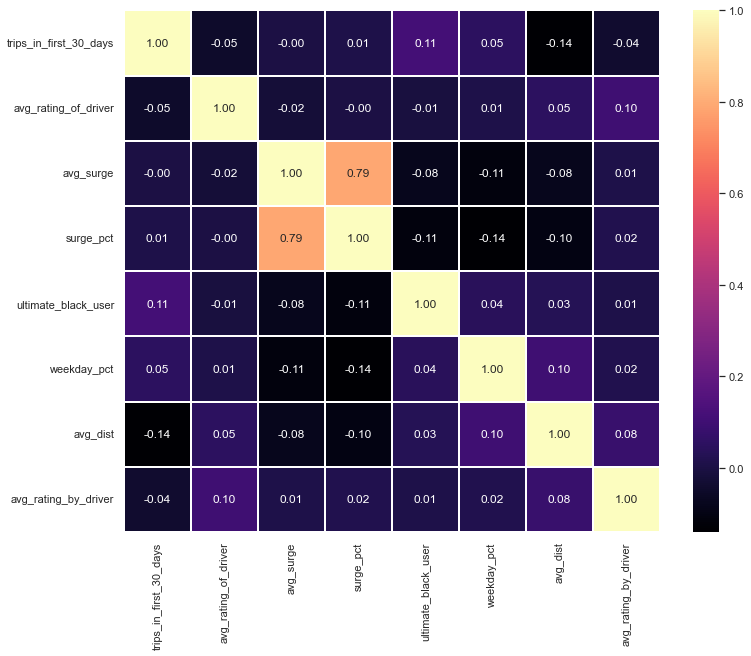

In [48]:
corrmat = dfx1.corr()
f, ax = plt.subplots(figsize=(12, 9))
hm = sns.heatmap(round(corrmat,2), annot=True, ax=ax, cmap='magma',fmt='.2f',
                 linewidths=.05)

f.subplots_adjust(top=0.93)

avg_surge and surge_pct are highly correlated - it may be wise to drop one of these variables

In [49]:
dfx1.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_status
0,King's Landing,4,2014-01-25,4.7,1.1,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,Y
1,Astapor,0,2014-01-29,5.0,1.0,2014-05-05,Android,0.0,False,50.0,8.26,5.0,N
2,Astapor,3,2014-01-06,4.3,1.0,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,N
3,King's Landing,9,2014-01-10,4.6,1.1400000000000001,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,Y
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,N


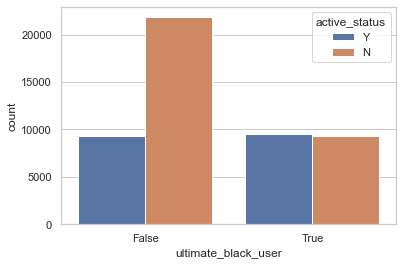

In [81]:
sns.countplot(x='ultimate_black_user', data=dfx1, hue='active_status');

Comment: it appears that users that are not ultimate_black_users have a much higher churn rate

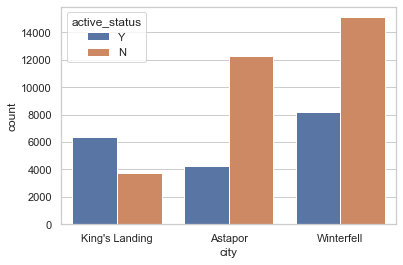

In [79]:
sns.countplot(x='city', data=dfx1, hue='active_status');

Comment: it appears that Astapor city and Winterfell have a much higher churn rate

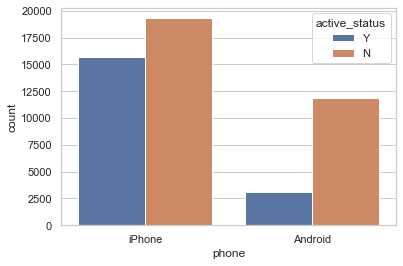

In [78]:
sns.countplot(x='phone', data=dfx1, hue='active_status');

Comment: it appears that users that Android users have a much higher churn rate

#### 2. Predictive model
 - Logistic regression
 - Random Forest
 - LightGBM


##### Create dummy variables for categorical data types

In [53]:
# isolate categorical variables
categorical_features = dfx1.select_dtypes(include=['object'])

# exclude dependent variable
categorical_features = categorical_features.drop(columns = ['active_status'])

dfx2 = pd.concat([dfx1.drop(categorical_features, axis=1), pd.get_dummies(categorical_features)], axis=1)

##### Split data into training and testing subsets

In [54]:
# Create the X and y matrices from the dataframe
X = dfx2.drop(columns = ['active_status'])
y = dfx2['active_status']

In [55]:
# train_test_split; reserve 20% for test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=23)

In [56]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

##### Scaling and Transforming Numeric Features

In [57]:
# Create subset of only the numeric columns
numeric_df = dfx2.select_dtypes(include=['int', 'float'])

In [58]:
numeric_column_names = list(numeric_df.columns)

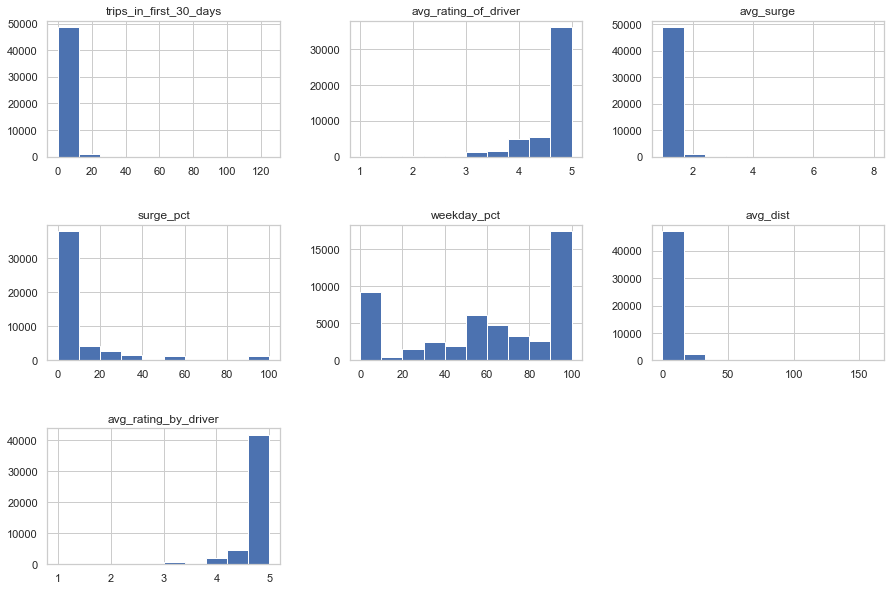

In [59]:
# let's look at the distribution of numeric variables
numeric_df.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5)

In [60]:
# isolate numeric features of X_train and X_test
numeric_df_X_train = X_train.select_dtypes(include=['int', 'float'])
numeric_df_X_test = X_test.select_dtypes(include=['int', 'float'])

In [61]:
# scale X_train and X_test
# this should make all values between 0 and 1
from sklearn.preprocessing import MinMaxScaler

# create model, fit, and transform
MM_scaler = MinMaxScaler()
numeric_df_mm_X_train = MM_scaler.fit_transform(numeric_df_X_train)
numeric_df_mm_X_test = MM_scaler.fit_transform(numeric_df_X_test)

# convert back to dataframe for plotting
numeric_df_mm_X_train = pd.DataFrame(numeric_df_mm_X_train)
numeric_df_mm_X_train.columns = numeric_column_names
numeric_df_mm_X_test = pd.DataFrame(numeric_df_mm_X_test)
numeric_df_mm_X_test.columns = numeric_column_names

#numeric_df_mm_X_train
# numeric_df_mm_X_test.hist(figsize=(15,10))
# plt.subplots_adjust(hspace=0.5)

In [62]:
for column_name in numeric_column_names:
    X_train[column_name] = numeric_df_mm_X_train[column_name]

In [63]:
for column_name in numeric_column_names:
    X_test[column_name] = numeric_df_mm_X_test[column_name]

### Load the datasets

In [64]:
X_train = pd.read_csv('X_train.csv', index_col =[0])
X_test = pd.read_csv('X_test.csv', index_col =[0])
y_train = pd.read_csv('y_train.csv', index_col =[0]) 
y_test = pd.read_csv('y_test.csv', index_col =[0])

eval_set = [(X_train, y_train), (X_test, y_test)]

#### <font color='orange'>Random Forest</font>

In [65]:
# using 3 estimators
rf_clf = RandomForestClassifier(random_state = 23, n_jobs=-1)
rf_clf.fit(X_train, y_train.values.ravel())
y_pred = rf_clf.predict(X_test)

# let's look at classification report
print("Classification Report for Training Data")
print(classification_report(y_train, rf_clf.predict(X_train)))
print("Classification Report for Test Data")
print(classification_report(y_test, rf_clf.predict(X_test)))

Classification Report for Training Data
              precision    recall  f1-score   support

           N       1.00      1.00      1.00     24910
           Y       1.00      1.00      1.00     15083

    accuracy                           1.00     39993
   macro avg       1.00      1.00      1.00     39993
weighted avg       1.00      1.00      1.00     39993

Classification Report for Test Data
              precision    recall  f1-score   support

           N       0.99      0.98      0.99      6278
           Y       0.97      0.98      0.98      3721

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999



30


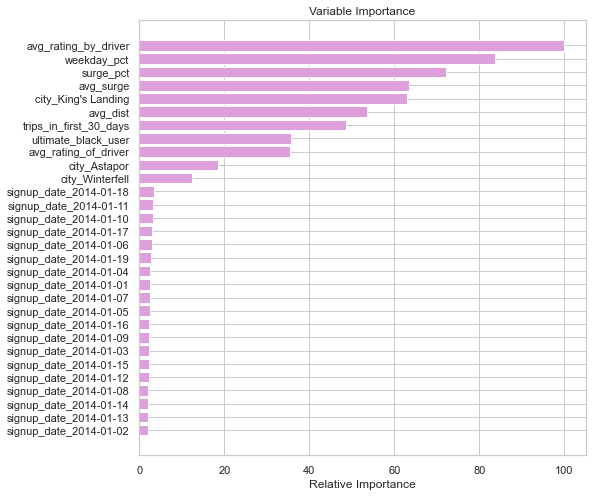

In [66]:
feature_importance = rf_clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(8,8))
plt.barh(pos, feature_importance[sorted_idx], align='center', color = 'plum')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

#### Hyperparameter Tuning- RandomizedSearchCV

In [67]:
# set the parameter grid
param_grid = {
    'n_estimators': [25, 50, 100, 150],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9],
}

In [68]:
# comment out to avoid lengthy run
# rf_clf_cv = RandomizedSearchCV(RandomForestClassifier(random_state=23),
#                                    param_grid)
# rf_clf_cv.fit(X_train, y_train.values.ravel())
# print(rf_clf_cv.best_estimator_)

##### Output of above:

1st run
RandomForestClassifier(max_depth=9, max_features='log2', max_leaf_nodes=9,
                       n_estimators=150, random_state=23)

2nd run
RandomForestClassifier(max_depth=9, max_features='log2', max_leaf_nodes=9,
                       random_state=23)





In [69]:
# update with CV
rf_clf_cv = RandomForestClassifier(max_depth=9, max_features='log2', max_leaf_nodes=9, n_estimators=150, random_state=23)
rf_clf_cv.fit(X_train, y_train.values.ravel())
y_pred = rf_clf_cv.predict(X_test)

# let's look at classification report
print("Classification Report for Training Data")
print(classification_report(y_train, rf_clf_cv.predict(X_train)))
print("Classification Report for Test Data")
print(classification_report(y_test, rf_clf_cv.predict(X_test)))

Classification Report for Training Data
              precision    recall  f1-score   support

           N       0.74      0.98      0.84     24910
           Y       0.94      0.43      0.59     15083

    accuracy                           0.77     39993
   macro avg       0.84      0.71      0.72     39993
weighted avg       0.81      0.77      0.75     39993

Classification Report for Test Data
              precision    recall  f1-score   support

           N       0.75      0.98      0.85      6278
           Y       0.93      0.44      0.59      3721

    accuracy                           0.78      9999
   macro avg       0.84      0.71      0.72      9999
weighted avg       0.81      0.78      0.75      9999



30


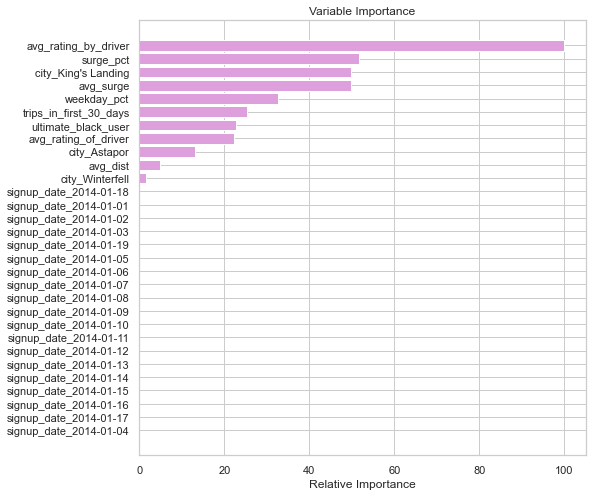

In [70]:
feature_importance = rf_clf_cv.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(8,8))
plt.barh(pos, feature_importance[sorted_idx], align='center', color = 'plum')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

#### <font color='orange'>Logistic Regression</font>

In [94]:
lr_clf = LogisticRegression(random_state = 23)
lr_clf.fit(X_train, y_train.values.ravel())
print("Classification Report for Training Data")
print(classification_report(y_train, lr_clf.predict(X_train)))
print("Classification Report for Test Data")
print(classification_report(y_test, lr_clf.predict(X_test)))

/Users/gregwelliver/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report for Training Data
              precision    recall  f1-score   support

           N       1.00      1.00      1.00     24910
           Y       1.00      1.00      1.00     15083

    accuracy                           1.00     39993
   macro avg       1.00      1.00      1.00     39993
weighted avg       1.00      1.00      1.00     39993

Classification Report for Test Data
              precision    recall  f1-score   support

           N       1.00      1.00      1.00      6278
           Y       1.00      1.00      1.00      3721

    accuracy                           1.00      9999
   macro avg       1.00      1.00      1.00      9999
weighted avg       1.00      1.00      1.00      9999



In [86]:
# set the parameter grid
param_grid = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [1, 3, 5],
}

In [93]:
# comment out to avoid lengthy run
lr_clf_cv = RandomizedSearchCV(LogisticRegression(max_iter=200), param_grid)
lr_clf_cv.fit(X_train, y_train.values.ravel())
print(lr_clf_cv.best_estimator_)

/Users/gregwelliver/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/gregwelliver/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/gregwelliver/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/gregwelliver/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/gregwelliver/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/gregwell

LogisticRegression(C=3, max_iter=200, solver='liblinear')


Output 1:
    
LogisticRegression(C=3, solver='saga')
had messages on max_iter was reached, which means the coef_ did not converge


Output 2: (max_iter=200)
LogisticRegression(C=3, max_iter=200, solver='liblinear')



In [95]:
lr_clf = LogisticRegression(C=3, solver='saga', random_state = 23)
lr_clf.fit(X_train, y_train.values.ravel())
print("Classification Report for Training Data")
print(classification_report(y_train, lr_clf.predict(X_train)))
print("Classification Report for Test Data")
print(classification_report(y_test, lr_clf.predict(X_test)))

/Users/gregwelliver/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification Report for Training Data
              precision    recall  f1-score   support

           N       1.00      1.00      1.00     24910
           Y       1.00      1.00      1.00     15083

    accuracy                           1.00     39993
   macro avg       1.00      1.00      1.00     39993
weighted avg       1.00      1.00      1.00     39993

Classification Report for Test Data
              precision    recall  f1-score   support

           N       1.00      1.00      1.00      6278
           Y       1.00      1.00      1.00      3721

    accuracy                           1.00      9999
   macro avg       1.00      1.00      1.00      9999
weighted avg       1.00      1.00      1.00      9999



In [96]:
lr_clf = LogisticRegression(C=3, max_iter=200, solver='liblinear', random_state = 23)
lr_clf.fit(X_train, y_train.values.ravel())
print("Classification Report for Training Data")
print(classification_report(y_train, lr_clf.predict(X_train)))
print("Classification Report for Test Data")
print(classification_report(y_test, lr_clf.predict(X_test)))

Classification Report for Training Data
              precision    recall  f1-score   support

           N       1.00      1.00      1.00     24910
           Y       1.00      1.00      1.00     15083

    accuracy                           1.00     39993
   macro avg       1.00      1.00      1.00     39993
weighted avg       1.00      1.00      1.00     39993

Classification Report for Test Data
              precision    recall  f1-score   support

           N       1.00      1.00      1.00      6278
           Y       1.00      1.00      1.00      3721

    accuracy                           1.00      9999
   macro avg       1.00      1.00      1.00      9999
weighted avg       1.00      1.00      1.00      9999



#### <font color='orange'>Light GBM</font>

In [72]:
# define the model
lgbm = LGBMClassifier(random_state=1234)
lgbm.fit(X_train, y_train, early_stopping_rounds=20, eval_set=eval_set)

/Users/gregwelliver/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gregwelliver/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618177	valid_1's binary_logloss: 0.616221
Training until validation scores don't improve for 20 rounds
[2]	training's binary_logloss: 0.573877	valid_1's binary_logloss: 0.573143
[3]	training's binary_logloss: 0.54154	valid_1's binary_logloss: 0.541231
[4]	training's binary_logloss: 0.509607	valid_1's binary_logloss: 0.510409
[5]	training's binary_logloss: 0.483805	valid_1's binary_logloss: 0.485275
[6]	training's binary_logloss: 0.442079	valid_1's binary_logloss: 0.44367
[7]	training's binary_logloss: 0.406871	valid_1's binary_logloss: 0.408531
[8]	training's binary_logloss: 0.389965	valid_1's binary_logloss: 0.391827
[9]	training's binary_logloss: 0.361675	valid_1's binary_logloss: 0.363546
[10]	training's binary_logloss: 0.320027	valid_1's binary_logloss: 0.321822
[11]	training's binary_logloss: 0.284065	valid_1's binary_logloss: 0.285777
[12]	training's binary_logloss: 0.252864	valid_1's binary_logloss: 0.254439
[13]	training's binary_logloss: 0.2256

LGBMClassifier(random_state=1234)

In [73]:
print("Classification Report for Training Data")
print(classification_report(y_train, lgbm.predict(X_train)))
print("Classification Report for Test Data")
print(classification_report(y_test, lgbm.predict(X_test)))

Classification Report for Training Data
              precision    recall  f1-score   support

           N       1.00      1.00      1.00     24910
           Y       1.00      1.00      1.00     15083

    accuracy                           1.00     39993
   macro avg       1.00      1.00      1.00     39993
weighted avg       1.00      1.00      1.00     39993

Classification Report for Test Data
              precision    recall  f1-score   support

           N       1.00      1.00      1.00      6278
           Y       1.00      1.00      1.00      3721

    accuracy                           1.00      9999
   macro avg       1.00      1.00      1.00      9999
weighted avg       1.00      1.00      1.00      9999



30


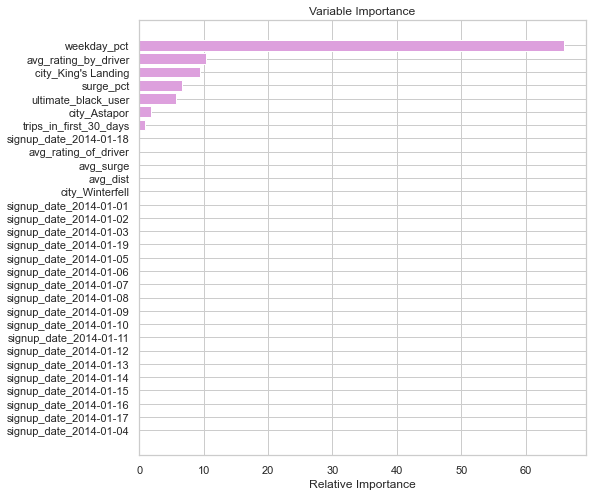

In [74]:
feature_importance = lgbm.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(8,8))
plt.barh(pos, feature_importance[sorted_idx], align='center', color = 'plum')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
# define the model
lgbm = LGBMClassifier(random_state=1234)
lgbm.fit(X_train, y_train, early_stopping_rounds=20, eval_set=eval_set)

In [ ]:
print("Classification Report for Training Data")
print(classification_report(y_train, lgbm.predict(X_train)))
print("Classification Report for Test Data")
print(classification_report(y_test, lgbm.predict(X_test)))

In [75]:
#dfx1[dfx1['avg_dist'] == 8.08]

#### write to CSV
from pathlib import Path  
filepath = Path('../Data/X_train.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
X_train.to_csv(filepath)

from pathlib import Path  
filepath = Path('../Data/X_test.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
X_test.to_csv(filepath)

from pathlib import Path  
filepath = Path('../Data/y_train.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
y_train.to_csv(filepath)

from pathlib import Path  
filepath = Path('../Data/y_test.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
y_test.to_csv(filepath)